# Predicting NEE on grid

In [1]:
import sys
import xarray as xr
import numpy as np
from joblib import load
from datacube.utils.dask import start_local_dask

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/dea_tools')
from classification import predict_xr

/home/547/cb3058/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40147,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:44709,Total threads: 16
Dashboard: /proxy/33167/status,Memory: 44.92 GiB
Nanny: tcp://127.0.0.1:46475,


### Open model

In [3]:
model = load('/g/data/os22/chad_tmp/NEE_modelling/results/AUS_NEE_model.joblib').set_params(n_jobs=1)

## Open predictor data

In [4]:
data0 = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/input_data/input_data_2017.nc',
                       chunks=dict(x=1000,y=1000))
data1 = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/input_data/input_data_2018.nc',
                       chunks=dict(x=1000,y=1000))
data2 = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/input_data/input_data_2019.nc',
                       chunks=dict(x=1000,y=1000))
data3 = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/input_data/input_data_2020.nc',
                       chunks=dict(x=1000,y=1000))

In [5]:
data = xr.concat([data0,data1,data2,data3], dim='time').sortby('time')

## Open variable names and index data into correct order

TO DO: make this programmatic

In [7]:
f = open("/g/data/os22/chad_tmp/NEE_modelling/results/variables.txt", "r")
variables = f.read()
variables = variables.split(",")
print(variables)

['Ta', 'Sws', 'Precip', 'lai', 'VPD', 'Ta_L1', 'Sws_L1', 'Precip_L1', 'lai_L1', 'VPD_L1', '']


In [8]:
data = data[['tavg','soil_moisture','rain','lai','vpd','tavg_L1','soil_moisture_L1','rain_L1','lai_L1','vpd_L1']]

### Predict each time-step seperately

- TO DO: fix timesteps that come back from `predict_xr`

In [9]:
# data=data.rename({'latitude':'y', 'longitude':'x'})
mask = ~np.isnan(data.lai.isel(time=1))

In [10]:
results = []
for i in range(1, len(data.time)): #start from 1 as first time-step doesn't have lags
    predicted = predict_xr(model,
                        data.isel(time=i),
                        proba=False,
                        clean=True,
                          ).compute()
    
    predicted = predicted.Predictions.where(mask)
    predicted['time'] = data.isel(time=i).time.values
    results.append(predicted)

predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...


In [13]:
nee = xr.concat(results, dim='time').sortby('time').rename('NEE').compute()
nee

<xarray.DataArray 'NEE' (time: 47, y: 3500, x: 4200)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float32 112.0 112.0 112.0 112.0 ... 154.0 154.0 154.0 154.0
  * y            (y) float32 -9.005 -9.015 -9.025 ... -43.97 -43.99 -43.99
    spatial_ref  int32 4283
  * time         (time) datetime64[ns] 2017-02-15 2017-03-15 ... 2020-12-15
Attributes:
    grid_mapping:  spatial_ref

In [14]:
nee.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/nee_AUS_model.nc')

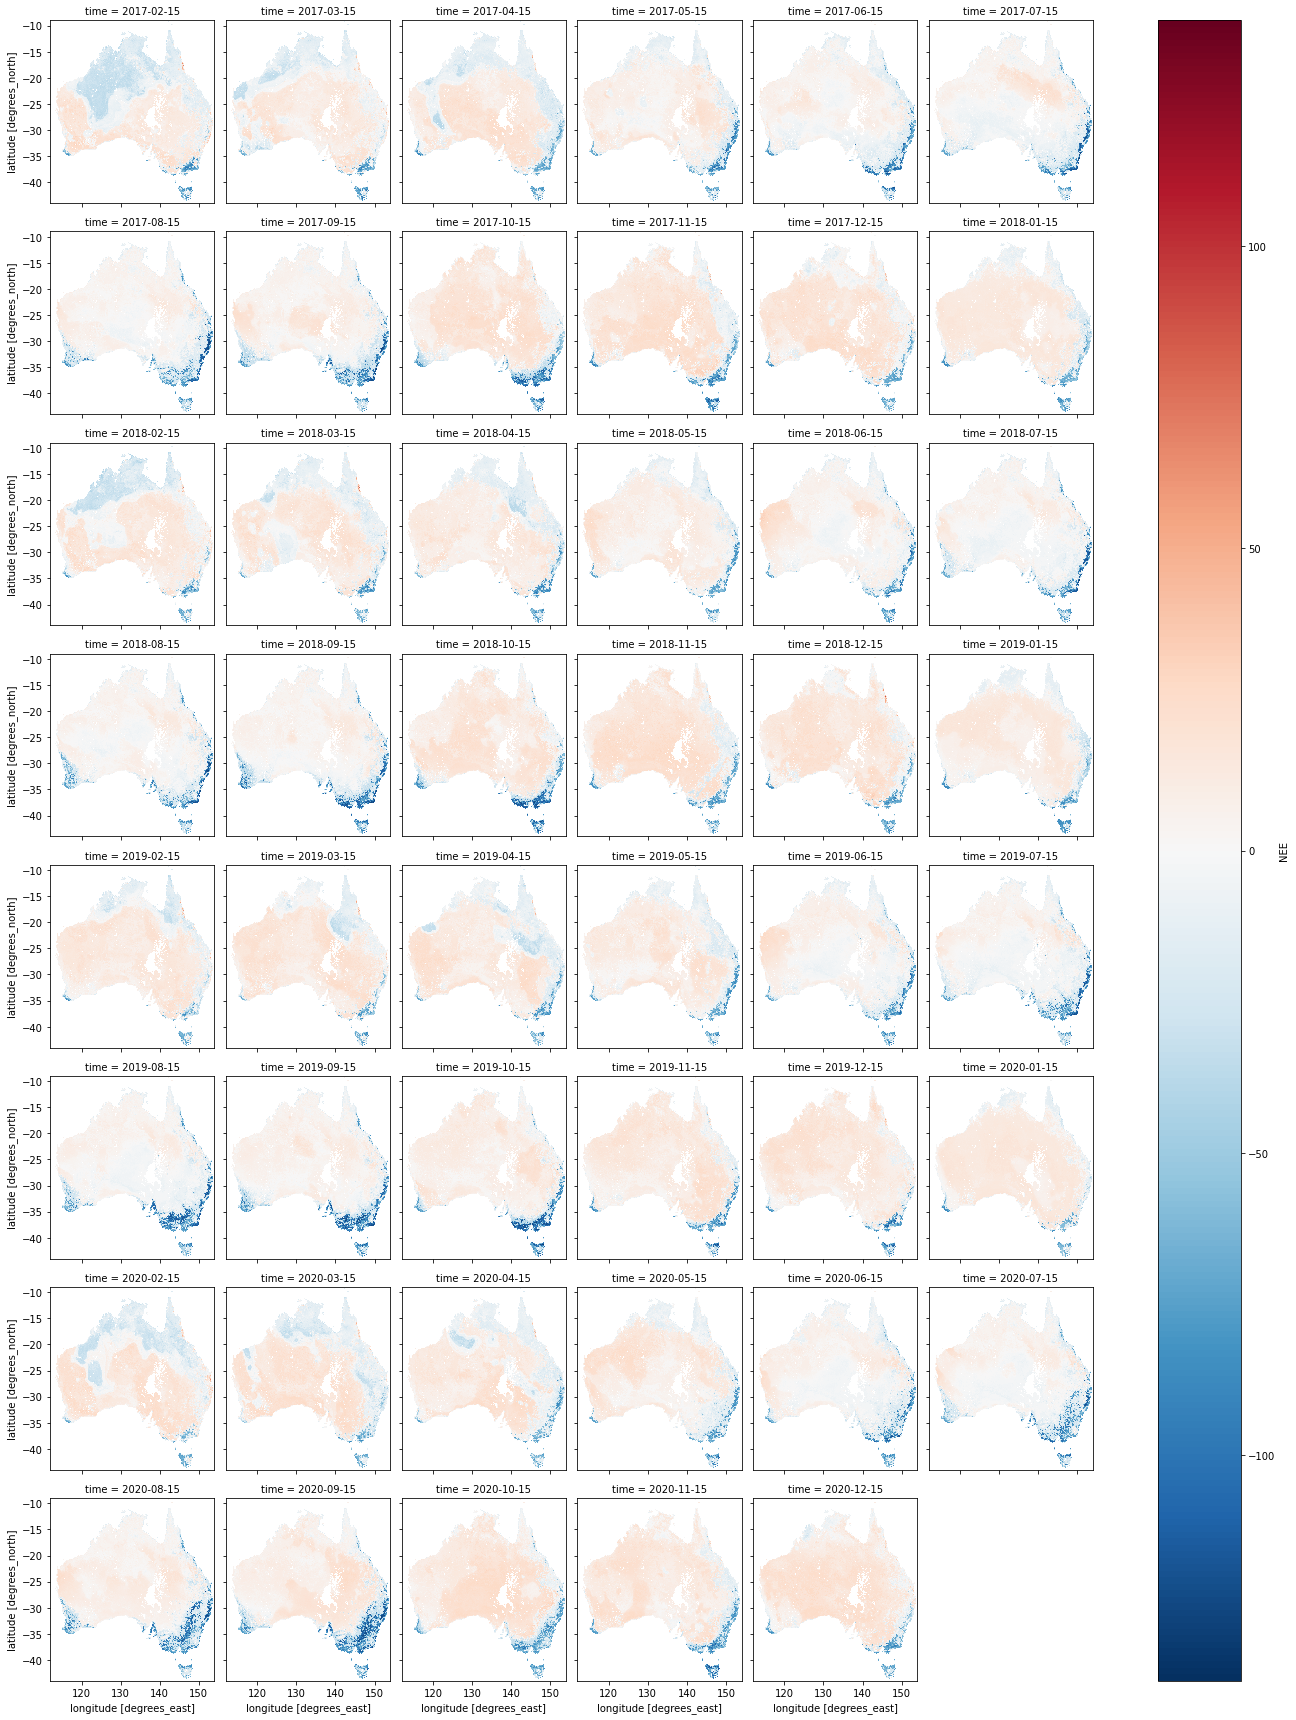

In [17]:
nee.plot.imshow(col='time', col_wrap=6);

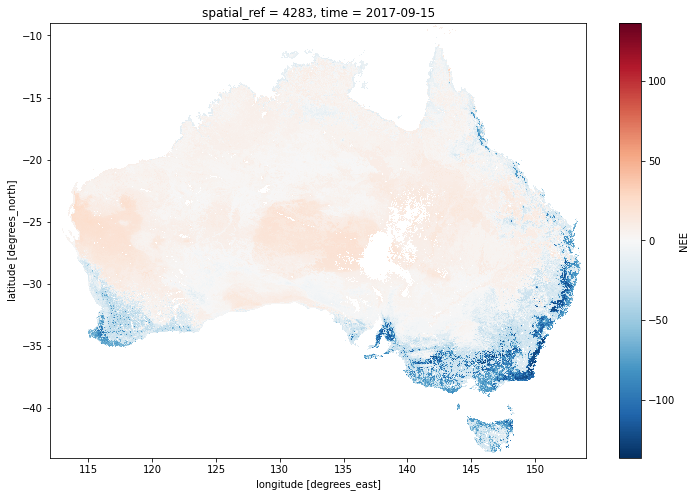

In [20]:
nee.isel(time=7).plot.imshow(size=8)

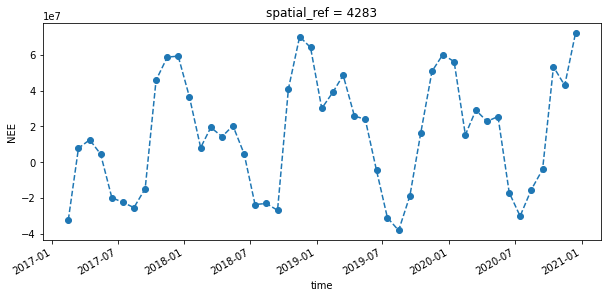

In [23]:
nee.sum(['x','y']).plot(figsize=(10,4), marker='o', linestyle='--')